In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, HTML
from scipy import integrate

from rp_utils import *

def fill_vel_grids(arr, axis):
    """
    Fill in the nan-initialized velocity grids
    with the last velocity value at that depth
    """
    mask = np.isnan(arr)
    idx = np.where(~mask,np.arange(mask.shape[1]),0)
    np.maximum.accumulate(idx,axis=axis, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

# Lunar Pressure vs Depth

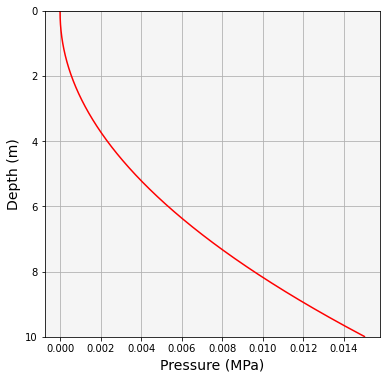

In [21]:
"""
Compute simple pressure to depth plot for lunar regolith
"""

## Acceleration due to gravity, in m/s
grav_accel = 1.625

## Depth range, in m
max_depth = 10
depth_step = 0.01
depths = np.arange(0,max_depth,depth_step)

## Density equation from Lunar Sourcebook, in g/cm3, page 494
densities = 1.92 * ((depths*100 + 12.2)/(depths*100 + 18))

## Pressure, in MPa
integrated_density = integrate.cumulative_trapezoid(densities)

pressures = np.cumsum((grav_accel * integrated_density * depth_step) / 1e6)
pressures = np.hstack((0, pressures))

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pressures, depths, color='red')
ax.set_ylim(max_depth,-0.01)
ax.set_xlabel('Pressure (MPa)', fontsize=14)
ax.set_ylabel('Depth (m)', fontsize=14)
ax.grid('both')
ax.set_facecolor('whitesmoke')
plt.show()

# Velocity Profiles

Combine rock physics models with porosity/pressure profiles to calculate velocity profiles

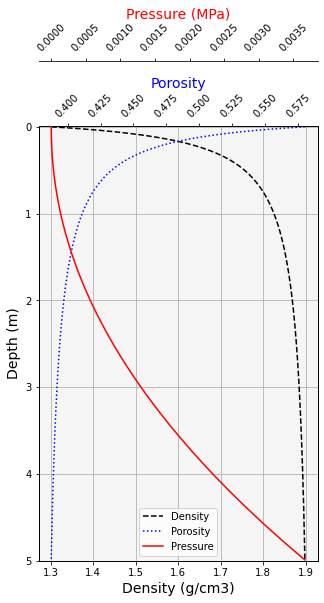

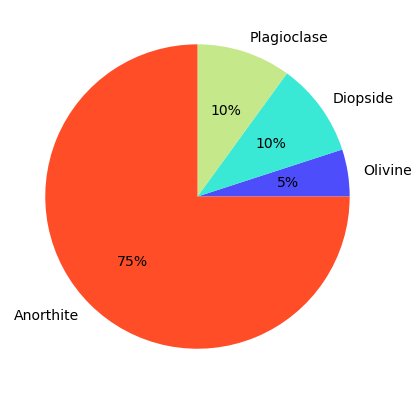

Constituent,Bulk Modulus (GPa),Shear Modulus (GPa),Density (g/cm3)
Anorthite,66.00,33.70,2.70
Plagioclase,75.60,25.60,2.63
Diopside,111.20,63.70,3.31
Olivine,130.00,80.00,3.32
Effective Mineral,73.13,36.74,2.79
Ice -160 C,10.34,3.42,0.81


In [9]:
"""
Material properties for velocity profiles below
"""


## REGOLITH AND ICE CONSTITUENTS

## Mineral Parameters and Mixing
minerals = ['Olivine', 'Diopside', 'Plagioclase', 'Anorthite']
k_olivine, u_olivine, f_olivine, d_olivine = 130, 80, 0.05, 3.32  #from RP handbook
k_diopside, u_diopside, f_diopside, d_diopside = 111.2, 63.7, 0.1, 3.31   #from RP handbook
k_plag, u_plag, f_plag, d_plag = 75.6, 25.6, 0.1, 2.63     #from RP handbook
k_anorthite, u_anorthite, f_anorthite, d_anorthite = 66., 33.7, 0.75, 2.7  # from Brown 2016

min_volume_fractions = [f_olivine, f_diopside, f_plag, f_anorthite]
min_bulk_mods = [k_olivine, k_diopside, k_plag, k_anorthite]
min_shear_mods = [u_olivine, u_diopside, u_plag, u_anorthite]
min_densities = [d_olivine, d_diopside, d_plag, d_anorthite]

assert len(minerals) == len(min_volume_fractions), "Check your minerals!"

effective_mineral_k = hill_average(min_volume_fractions, min_bulk_mods)
effective_mineral_u = hill_average(min_volume_fractions, min_shear_mods)
eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])


## Ice Parameters
ice_temp = -160
# ice_vp = (-2.3*ice_temp + 3795) / 1000  # from Kohnen 1974
# ice_vs = (-1.2*ice_temp + 1915) / 1000
# ice_dens = 0.96
ice_vp = (3837.9 - 2.812*ice_temp) / 1000  # from Vogt 2008
ice_vs = (1826 - 1.425*ice_temp) / 1000
# ice_dens = (917 - 0.1403*ice_temp) / 1000 # from Pounder 1965
ice_dens = 0.81

k_ice = bulk_mod(ice_vp, ice_vs, ice_dens)
u_ice = shear_mod(ice_vs, ice_dens)




##  SUBSURFACE PROPERTIES
##  POROSITY, DENSITY, PRESSURE PROFILES

## Acceleration due to gravity, in m/s
grav_accel = 1.625

## Specific gravity of regolith
# specific_gravity = eff_min_density
specific_gravity = 3.1

## Depth range, in m
max_depth = 5
depth_step = 0.01
depths = np.arange(0,max_depth,depth_step)

## Density equation from Lunar Sourcebook, in g/cm3, page 494
densities = 1.92 * ((depths*100 + 12.2)/(depths*100 + 18))

## Porosity equation from Lunar Sourcebook
porosities = 1 - (densities / specific_gravity)

## Pressure, in MPa
integrated_density = integrate.cumulative_trapezoid(densities)

pressures = np.cumsum((grav_accel * integrated_density * depth_step) / 1e6)
pressures = np.hstack((0, pressures))


##-------------------------------------------------
## PLOTS


## Pressure / Density / Porosity Plot
fig, ax = plt.subplots(figsize=(5,8))

twin1 = ax.twiny()
twin2 = ax.twiny()

twin2.spines.top.set_position(("axes", 1.15))

dens_plot = ax.plot(densities, depths, '--', label='Density', color='black')
por_plot = twin1.plot(porosities, depths, ':', label='Porosity', color='blue')
pres_plot = twin2.plot(pressures, depths, label='Pressure', color='red')

twin1.tick_params(rotation=45)
twin2.tick_params(rotation=45)

ax.set_xlabel("Density (g/cm3)", fontsize=14)
ax.set_ylabel("Depth (m)", fontsize=14)
twin1.set_xlabel("Porosity", fontsize=14)
twin2.set_xlabel("Pressure (MPa)", fontsize=14)

ax.xaxis.label.set_color(dens_plot[0].get_color())
twin1.xaxis.label.set_color(por_plot[0].get_color())
twin2.xaxis.label.set_color(pres_plot[0].get_color())

ax.legend(handles=[dens_plot[0], por_plot[0], pres_plot[0]], loc='lower center')
ax.grid('both')
ax.set_facecolor('whitesmoke')

plt.ylim(max_depth,-0.01)

plt.show()


## Pie chart of mineral constituents
n_colors = len(minerals)
plot_colors = plt.cm.rainbow(np.linspace(0.1,0.9,n_colors))

plt.figure(figsize=(7,7))
plt.pie(min_volume_fractions, labels=minerals, autopct='%1.f%%', textprops={'fontsize': 14}, colors=plot_colors)
plt.show()


## Table of constituent properties
table_data = [['Anorthite', k_anorthite, u_anorthite, d_anorthite],
             ['Plagioclase', k_plag, u_plag, d_plag],
             ['Diopside', k_diopside, u_diopside, d_diopside],
             ['Olivine', k_olivine, u_olivine, d_olivine],
             ['Effective Mineral', round(effective_mineral_k,2), round(effective_mineral_u,2), round(eff_min_density,2)],
             ['Ice {} C'.format(ice_temp), round(k_ice,2), round(u_ice,2), round(ice_dens,2)]]

table_df = pd.DataFrame(table_data, columns=['Constituent', 'Bulk Modulus (GPa)',
                                            'Shear Modulus (GPa)', 'Density (g/cm3)'])

HTML(table_df.to_html(index=False))

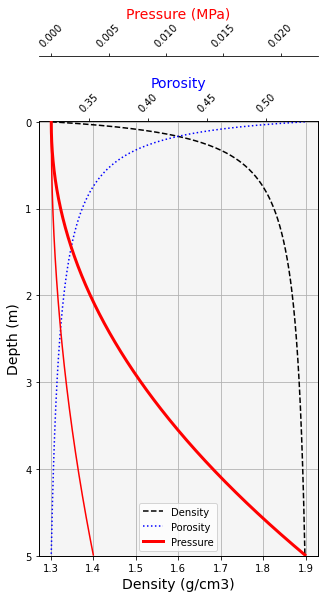

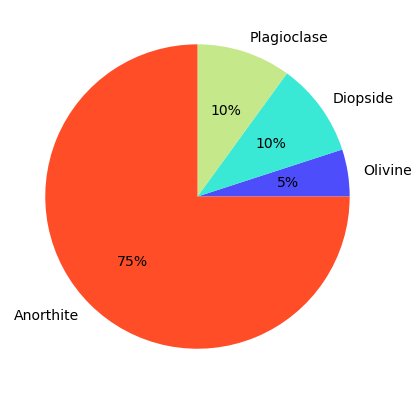

Constituent,Bulk Modulus (GPa),Shear Modulus (GPa),Density (g/cm3)
Anorthite,66.00,33.70,2.70
Plagioclase,75.60,25.60,2.63
Diopside,111.20,63.70,3.31
Olivine,130.00,80.00,3.32
Effective Mineral,73.13,36.74,2.79
Ice -160 C,11.99,3.96,0.94


In [19]:
"""
Material properties for velocity profiles below
"""


## REGOLITH AND ICE CONSTITUENTS

## Mineral Parameters and Mixing
minerals = ['Olivine', 'Diopside', 'Plagioclase', 'Anorthite']
k_olivine, u_olivine, f_olivine, d_olivine = 130, 80, 0.05, 3.32  #from RP handbook
k_diopside, u_diopside, f_diopside, d_diopside = 111.2, 63.7, 0.1, 3.31   #from RP handbook
k_plag, u_plag, f_plag, d_plag = 75.6, 25.6, 0.1, 2.63     #from RP handbook
k_anorthite, u_anorthite, f_anorthite, d_anorthite = 66., 33.7, 0.75, 2.7  # from Brown 2016

min_volume_fractions = [f_olivine, f_diopside, f_plag, f_anorthite]
min_bulk_mods = [k_olivine, k_diopside, k_plag, k_anorthite]
min_shear_mods = [u_olivine, u_diopside, u_plag, u_anorthite]
min_densities = [d_olivine, d_diopside, d_plag, d_anorthite]

assert len(minerals) == len(min_volume_fractions), "Check your minerals!"

effective_mineral_k = hill_average(min_volume_fractions, min_bulk_mods)
effective_mineral_u = hill_average(min_volume_fractions, min_shear_mods)
eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])


## Ice Parameters
ice_temp = -160
# ice_vp = (-2.3*ice_temp + 3795) / 1000  # from Kohnen 1974
# ice_vs = (-1.2*ice_temp + 1915) / 1000
# ice_dens = 0.96
ice_vp = (3837.9 - 2.812*ice_temp) / 1000  # from Vogt 2008
ice_vs = (1826 - 1.425*ice_temp) / 1000
# ice_dens = (917 - 0.1403*ice_temp) / 1000 # from Pounder 1965
ice_dens = 0.81

k_ice = bulk_mod(ice_vp, ice_vs, ice_dens)
u_ice = shear_mod(ice_vs, ice_dens)




##  SUBSURFACE PROPERTIES
##  POROSITY, DENSITY, PRESSURE PROFILES

## Acceleration due to gravity, in m/s
grav_accel = 1.625
grav_accel_earth = 9.8

## Specific gravity of regolith
specific_gravity = eff_min_density

## Depth range, in m
max_depth = 5
depth_step = 0.01
depths = np.arange(0,max_depth,depth_step)

## Density equation from Lunar Sourcebook, in g/cm3, page 494
densities = 1.92 * ((depths*100 + 12.2)/(depths*100 + 18))

## Porosity equation from Lunar Sourcebook
porosities = 1 - (densities / specific_gravity)

## Pressure, in MPa

integrated_density = integrate.cumulative_trapezoid(densities)

pressures = np.cumsum((grav_accel * integrated_density * depth_step) / 1e6)
pressures = np.hstack((0, pressures))

pressures_earth = np.cumsum((grav_accel_earth * integrated_density * depth_step) / 1e6)
pressures_earth = np.hstack((0, pressures_earth))


##-------------------------------------------------
## PLOTS


## Pressure / Density / Porosity Plot
fig, ax = plt.subplots(figsize=(5,8))

twin1 = ax.twiny()
twin2 = ax.twiny()

twin2.spines.top.set_position(("axes", 1.15))

dens_plot = ax.plot(densities, depths, '--', label='Density', color='black')
por_plot = twin1.plot(porosities, depths, ':', label='Porosity', color='blue')
pres_plot = twin2.plot(pressures, depths, label='Pressure', color='red')
pres_plot = twin2.plot(pressures_earth, depths, label='Pressure', color='red', linewidth=3)

twin1.tick_params(rotation=45)
twin2.tick_params(rotation=45)

ax.set_xlabel("Density (g/cm3)", fontsize=14)
ax.set_ylabel("Depth (m)", fontsize=14)
twin1.set_xlabel("Porosity", fontsize=14)
twin2.set_xlabel("Pressure (MPa)", fontsize=14)

ax.xaxis.label.set_color(dens_plot[0].get_color())
twin1.xaxis.label.set_color(por_plot[0].get_color())
twin2.xaxis.label.set_color(pres_plot[0].get_color())

ax.legend(handles=[dens_plot[0], por_plot[0], pres_plot[0]], loc='lower center')
ax.grid('both')
ax.set_facecolor('whitesmoke')

plt.ylim(max_depth,-0.01)

plt.show()


## Pie chart of mineral constituents
n_colors = len(minerals)
plot_colors = plt.cm.rainbow(np.linspace(0.1,0.9,n_colors))

plt.figure(figsize=(7,7))
plt.pie(min_volume_fractions, labels=minerals, autopct='%1.f%%', textprops={'fontsize': 14}, colors=plot_colors)
plt.show()


## Table of constituent properties
table_data = [['Anorthite', k_anorthite, u_anorthite, d_anorthite],
             ['Plagioclase', k_plag, u_plag, d_plag],
             ['Diopside', k_diopside, u_diopside, d_diopside],
             ['Olivine', k_olivine, u_olivine, d_olivine],
             ['Effective Mineral', round(effective_mineral_k,2), round(effective_mineral_u,2), round(eff_min_density,2)],
             ['Ice {} C'.format(ice_temp), round(k_ice,2), round(u_ice,2), round(ice_dens,2)]]

table_df = pd.DataFrame(table_data, columns=['Constituent', 'Bulk Modulus (GPa)',
                                            'Shear Modulus (GPa)', 'Density (g/cm3)'])

HTML(table_df.to_html(index=False))

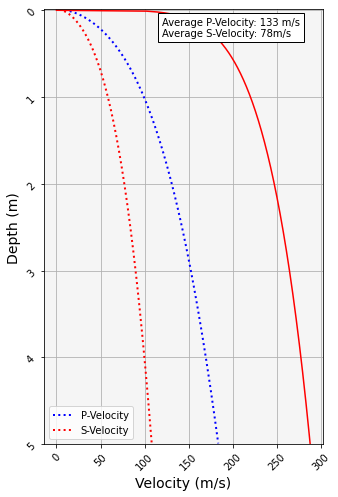

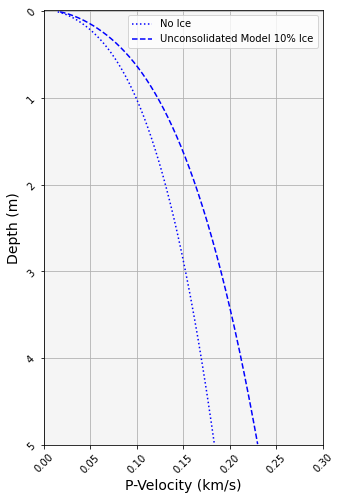

In [19]:
"""
Models 1D velocity profiles for a static ice concentration down to 5 m.
Ice should be less that porosity value at 5 m. Model assumes a density
function with depth (from Lunar Sourcebook/Apollo samples) and that ice 
is reducing the porosity of the existing regolith, therefore ice concentration
cannot be higher than this porosity inferred from density.
"""


## SET ICE CONCENTRATION
ice_concentration = 0.1

rc = 0.005
cohesionless_percent = 1





vp_unconsolidated = []
vs_unconsolidated = []
vp_stiff = []
vs_stiff = []
vp_cemented = []
vs_cemented = []
vp_dry = []
vs_dry = []



for i in range(len(depths)):
    
    # Skip first loop so equations don't break
    if i == 0:
        continue
        
    critical_porosity = porosities[0]
    regolith_porosity = porosities[i]
    total_porosity = regolith_porosity - ice_concentration
    assert total_porosity >= 0, "Ice concentration too high for porosity"
    
    pressure = pressures[i] / 1000
    
    C_regolith = lower_murphy(regolith_porosity)
    C_icy_mix = lower_murphy(total_porosity)
#     C_regolith = 4
#     C_icy_mix = 4


    ## HERTZ MINDLIN POINT FOR INPUT TO MODELS
    Khm, Uhm = hertz_mindlin_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C_regolith,
                                     pressure, Rc_ratio = rc, cohesionless_percent=cohesionless_percent)
    

    ## DRY REGOLITH, NO ICE
    k_dry, u_dry = uncemented_model(regolith_porosity, critical_porosity, Khm, Uhm, 
                                    effective_mineral_k, effective_mineral_u)
    
    dens_dry = eff_min_density * (1-regolith_porosity)
    vp_dry.append(p_vel_mod(k_dry, u_dry, dens_dry))
    vs_dry.append(s_vel_mod(u_dry, dens_dry))
    
    
    ## UNCONSOLIDATED MODEL & STIFF MODEL
    ## Mix ice and regolith
    vol_fracts = [1-regolith_porosity, ice_concentration]
    fract_sum = sum(vol_fracts)
    vol_fracts = [i/fract_sum for i in vol_fracts]
    bulk_mods = [effective_mineral_k, k_ice]
    shear_mods = [effective_mineral_u, u_ice]
    rhos = [eff_min_density, ice_dens]
    k_mix = hill_average(vol_fracts, bulk_mods)
    u_mix = hill_average(vol_fracts, shear_mods)
    dens_mix = sum([f*d for f, d in zip(vol_fracts, rhos)]) * (1-total_porosity)
    
    k_uncon, mu_uncon = uncemented_model(total_porosity, critical_porosity, Khm, Uhm, k_mix, u_mix)
    vp_unconsolidated.append(p_vel_mod(k_uncon, mu_uncon, dens_mix))
    vs_unconsolidated.append(s_vel_mod(mu_uncon, dens_mix))
    
    k_stiff, mu_stiff = stiff_model(total_porosity, critical_porosity, Khm, Uhm, k_mix, u_mix)
    vp_stiff.append(p_vel_mod(k_stiff, mu_stiff, dens_mix))
    vs_stiff.append(s_vel_mod(mu_stiff, dens_mix))
    
    
#     ## CEMENTED MODEL
#     ## Assume cement transitions to filling at 15% or pore space
#     transition_porosity = round(regolith_porosity-(regolith_porosity*.15), 2)
    
#     k_contact, u_contact, por_contact = self_consistent_contact_cement(k_ice, u_ice, effective_mineral_k, 
#                                         effective_mineral_u, transition_porosity, critical_porosity, C_regolith, 
#                                         scheme='contact')
    
#     cem_idx = np.abs(por_contact - (regolith_porosity-ice_concentration)).argmin()
    
#     vp_cemented.append(p_vel_mod(k_contact[cem_idx], u_contact[cem_idx], dens_mix))
#     vs_cemented.append(s_vel_mod(u_contact[cem_idx], dens_mix))
    
    
    
vp_dry = np.hstack((np.nan, np.array(vp_dry)))
vs_dry = np.hstack((np.nan, np.array(vs_dry)))   
    
vp_unconsolidated = np.hstack((np.nan, np.array(vp_unconsolidated)))
vs_unconsolidated = np.hstack((np.nan, np.array(vs_unconsolidated)))

vp_stiff = np.hstack((np.nan, np.array(vp_stiff)))
vs_stiff = np.hstack((np.nan, np.array(vs_stiff)))

# vp_cemented = np.hstack((np.nan, np.array(vp_cemented)))
# vs_cemented = np.hstack((np.nan, np.array(vs_cemented)))

############
### PLOTS


## Dry regolith only
fig, ax = plt.subplots(figsize=(5,8))

dry_plot_vp = ax.plot(vp_dry*1000, depths, ':', label='P-Velocity', color='blue', linewidth=2)
dry_plot_vs = ax.plot(vs_dry*1000, depths, ':', label='S-Velocity', color='red', linewidth=2)

ax.tick_params(rotation=45)

ax.set_xlabel("Velocity (m/s)", fontsize=14)
ax.set_ylabel("Depth (m)", fontsize=14)


# ax.set_xlim(0,np.nanmax(vp_dry*1000)*1.05)
ax.grid('both')
ax.set_facecolor('whitesmoke')
plt.ylim(5,-0.01)
plt.legend(loc = 'lower left')

vp_text = round(np.nanmean(vp_dry)*1000)
vs_text = round(np.nanmean(vs_dry)*1000)
plot_text = 'Average P-Velocity: {} m/s\nAverage S-Velocity: {}m/s'.format(vp_text, vs_text)
ax.text(120, 0.3, plot_text, fontsize = 10, 
         bbox = dict(facecolor = 'white'))

# # Power Law (Gangi)
power_vels = (220 * depths**(1/6))
ax.plot(power_vels, depths, color='red')

plt.show()



## Dry and icy regolith
fig, ax = plt.subplots(figsize=(5,8))
# twin1 = ax.twiny()

dry_plot_vp = ax.plot(vp_dry, depths, ':', label='No Ice', color='blue')
uncon_plot_vp = ax.plot(vp_unconsolidated, depths, '--', 
                        label='Unconsolidated Model {}% Ice'.format(int(ice_concentration*100)), color='blue')
# cem_plot_vp = ax.plot(vp_cemented, depths, 
#                       label='Cemented Model  {}% Ice'.format(int(ice_concentration*100)), color='blue')
# stiff_plot_vp = ax.plot(vp_stiff, depths, '-.', 
#                         label='Stiff Model {}% Ice'.format(int(ice_concentration*100)), color='blue')

# dry_plot_vs = twin1.plot(vs_dry, depths, ':', color='red')
# uncon_plot_vs = twin1.plot(vs_unconsolidated, depths, '--', color='red')
# stiff_plot_vs = twin1.plot(vs_stiff, depths, '-.', color='red')
# cem_plot_vs = twin1.plot(vs_cemented, depths, color='red')

ax.tick_params(rotation=45)
# twin1.tick_params(rotation=45)

ax.set_xlabel("P-Velocity (km/s)", fontsize=14)
ax.set_ylabel("Depth (m)", fontsize=14)
# twin1.set_xlabel("S-Velocity (km/s)", fontsize=14)

ax.set_xlim(0,.3)
# twin1.set_xlim(0, 3)

ax.grid('both')
ax.set_facecolor('whitesmoke')

# ax.xaxis.label.set_color(uncon_plot_vp[0].get_color())
# twin1.xaxis.label.set_color(uncon_plot_vs[0].get_color())

# ax.legend(handles=[dry_plot_vp[0], uncon_plot_vp[0], cem_plot_vp[0]])
ax.legend(handles=[dry_plot_vp[0], uncon_plot_vp[0]])
plt.ylim(5,-0.01)

plt.show()

In [54]:
"""
Model series of 1D models for varying ice concentration
and stack models into 2D array
"""

start = time.time()


## Angularity parameter for HM
rc = 0.005
cohesionless_percent = 0.5


ice_range = np.arange(0, .5, 0.01)


vp_unconsolidated_grid = np.empty((len(depths), len(ice_range)))
vs_unconsolidated_grid = np.empty((len(depths), len(ice_range)))
vp_cemented_grid = np.empty((len(depths), len(ice_range)))
vs_cemented_grid = np.empty((len(depths), len(ice_range)))
vp_unconsolidated_grid[:] = np.nan
vs_unconsolidated_grid[:] = np.nan
vp_cemented_grid[:] = np.nan
vs_cemented_grid[:] = np.nan


for I, ice_concentration in enumerate(ice_range):
    
    vp_unconsolidated_tmp = []
    vs_unconsolidated_tmp = []
    vp_cemented_tmp = []
    vs_cemented_tmp = []
    
    for i in range(len(depths)):

        # Skip first loop so equations don't break
        if i == 0:
            continue

        critical_porosity = porosities[0]
        regolith_porosity = porosities[i]
        total_porosity = regolith_porosity - ice_concentration

        pressure = pressures[i] / 1000

        C_regolith = lower_murphy(regolith_porosity)
        C_icy_mix = lower_murphy(total_porosity)
#         C_regolith = 4
#         C_icy_mix = 4
    
        ## ICE AMOUNT HIGHER THAN POROSITY VALUE
        if  total_porosity < 0:
            vp_unconsolidated_tmp.append(np.nan)
            vs_unconsolidated_tmp.append(np.nan)
            vp_cemented_tmp.append(np.nan)
            vs_cemented_tmp.append(np.nan)
            continue
        
        
        ## HERTZ MINDLIN POINT FOR INPUT TO MODELS
        Khm, Uhm = hertz_mindlin_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C_regolith,
                                     pressure, Rc_ratio = rc, cohesionless_percent=cohesionless_percent)


        ## DRY REGOLITH, NO ICE
        if ice_concentration == 0:
            k_dry, u_dry = uncemented_model(regolith_porosity, critical_porosity, Khm, Uhm, 
                                    effective_mineral_k, effective_mineral_u)
            
            dens_dry = eff_min_density * (1-regolith_porosity)
            
            vp_unconsolidated_tmp.append(p_vel_mod(k_dry, u_dry, dens_dry))
            vs_unconsolidated_tmp.append(s_vel_mod(u_dry, dens_dry))
            vp_cemented_tmp.append(p_vel_mod(k_dry, u_dry, dens_dry))
            vs_cemented_tmp.append(s_vel_mod(u_dry, dens_dry))


            
        if ice_concentration != 0:
            ## UNCONSOLIDATED MODEL
            ## Mix ice and regolith
            vol_fracts = [1-regolith_porosity, ice_concentration]
            fract_sum = sum(vol_fracts)
            vol_fracts = [i/fract_sum for i in vol_fracts]
            bulk_mods = [effective_mineral_k, k_ice]
            shear_mods = [effective_mineral_u, u_ice]
            rhos = [eff_min_density, ice_dens]
            k_mix = hill_average(vol_fracts, bulk_mods)
            u_mix = hill_average(vol_fracts, shear_mods)
            dens_mix = sum([f*d for f, d in zip(vol_fracts, rhos)]) * (1-total_porosity)

            k_uncon, mu_uncon = uncemented_model(total_porosity, critical_porosity, Khm, Uhm, k_mix, u_mix)

            vp_unconsolidated_tmp.append(p_vel_mod(k_uncon, mu_uncon, dens_mix))
            vs_unconsolidated_tmp.append(s_vel_mod(mu_uncon, dens_mix))


            ## CEMENTED MODEL
            ## Assume cement transitions to filling at 15% or pore space
            transition_porosity = round(regolith_porosity-(regolith_porosity*.15), 2)

            k_contact, u_contact, por_contact = self_consistent_contact_cement(k_ice, u_ice, effective_mineral_k, 
                                                effective_mineral_u, transition_porosity, critical_porosity, C_regolith, 
                                                scheme='contact')

            cem_idx = np.abs(por_contact - (regolith_porosity-ice_concentration)).argmin()

            vp_cemented_tmp.append(p_vel_mod(k_contact[cem_idx], u_contact[cem_idx], dens_mix))
            vs_cemented_tmp.append(s_vel_mod(u_contact[cem_idx], dens_mix))
  

    vp_unconsolidated_tmp = np.hstack((np.nan, np.array(vp_unconsolidated_tmp)))
    vs_unconsolidated_tmp = np.hstack((np.nan, np.array(vs_unconsolidated_tmp)))
    vp_cemented_tmp = np.hstack((np.nan, np.array(vp_cemented_tmp)))
    vs_cemented_tmp = np.hstack((np.nan, np.array(vs_cemented_tmp)))
    
    vp_unconsolidated_grid[:, I] = vp_unconsolidated_tmp
    vs_unconsolidated_grid[:, I] = vs_unconsolidated_tmp
    vp_cemented_grid[:, I] = vp_cemented_tmp
    vs_cemented_grid[:, I] = vs_cemented_tmp
    
    clear_output(wait=True)
    print("Completed modeling {}/{} ice concentrations".format(I+1, len(ice_range)))
    
# vp_unconsolidated_grid = fill_vel_grids(vp_unconsolidated_grid, axis=1)
# vs_unconsolidated_grid = fill_vel_grids(vs_unconsolidated_grid, axis=1)
# vp_cemented_grid = fill_vel_grids(vp_cemented_grid, axis=1)
# vs_cemented_grid = fill_vel_grids(vs_cemented_grid, axis=1)


end = time.time()
clear_output(wait=True)
print("Modeling completed in {} min.".format(round((end-start)/60, 1)))

Modeling completed in 0.3 min.


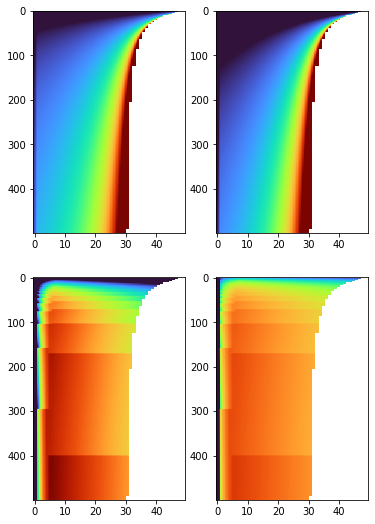

In [24]:
## PLOTS

# testing heat map plots


vp_min, vp_max = 0.3, 4.5
vs_min, vs_max = 0.1, 3.5

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (6,9))

ax[0,0].imshow(vp_unconsolidated_grid, aspect='auto', cmap='turbo', vmin=0.1, vmax=0.8)
ax[0,1].imshow(vs_unconsolidated_grid, aspect='auto', cmap='turbo', vmin=0.1, vmax=0.5)

ax[1,0].imshow(vp_cemented_grid, aspect='auto', cmap='turbo', vmin=2.8, vmax=3.5)
ax[1,1].imshow(vs_cemented_grid, aspect='auto', cmap='turbo', vmin=1.5, vmax=2.5)

plt.show()

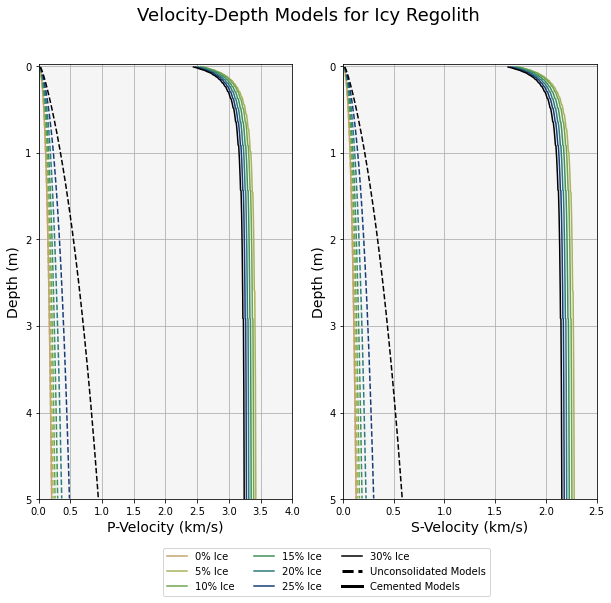

In [55]:
plot_ice_concentrations = [0, 5, 10, 15, 20, 25, 30]

n_colors = len(plot_ice_concentrations)
plot_colors = plt.cm.gist_earth_r(np.linspace(0.2,1,n_colors))




fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
ice_labels=[]

for i,I in enumerate(plot_ice_concentrations):
    ice_label = '{:.0f}% Ice'.format(I)
    
    uncon_plot_vp = ax[0].plot(vp_unconsolidated_grid[:,I], depths, '--', color=plot_colors[i])
    cem_plot_vp = ax[0].plot(vp_cemented_grid[:,I], depths, label=ice_label, color=plot_colors[i])
    
    uncon_plot_vs = ax[1].plot(vs_unconsolidated_grid[:,I], depths, '--', color=plot_colors[i])
    cem_plot_vs = ax[1].plot(vs_cemented_grid[:,I], depths, label=ice_label, color=plot_colors[i])
    
    ice_labels.append(cem_plot_vp)
    
for i in range(2):
    unc_lab = ax[i].plot(np.full(5, -20), np.full(5, -20),'--', label='Unconsolidated Models', linewidth=3, color='black')
    cem_lab = ax[i].plot(np.full(5, -20), np.full(5, -20), label='Cemented Models', linewidth=3, color='black')
    
    ax[i].set_ylabel("Depth (m)", fontsize=14)
    ax[i].grid('both')
    ax[i].set_facecolor('whitesmoke')
    ax[i].set_ylim(5,-0.02)
    

ax[0].set_xlabel("P-Velocity (km/s)", fontsize=14)
ax[1].set_xlabel("S-Velocity (km/s)", fontsize=14)
ax[0].set_xlim(0,4)
ax[1].set_xlim(0,2.5)

ice_labels.append(unc_lab)
ice_labels.append(cem_lab)
ax[1].legend(handles=[i[0] for i in ice_labels], bbox_to_anchor=(0.6, -0.1), ncol=3)

# # Power Law (Gangi)
# power_vels = (220 * depths**(1/6))/1000
# ax[0].plot(power_vels, depths, color='red')

fig.suptitle("Velocity-Depth Models for Icy Regolith", fontsize=18)
plt.show()